# Definitions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
import os, os.path
import win32com.client
import xlwings as xw
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Display entire Scenario string in notebook
pd.options.display.max_colwidth = 4000

# Functions

In [2]:
def read_from_new_DSS(DSS_file_path, output_tab, model_order):
    
    # Read calc data from Excel
    columns_from_excel = 'F,G,I,T,V,X,Z,U,KU,LE,MK'
    column_headers = ['scenarios', 'cash_delta', 'finance_delta', 'lease_delta', 'DC_delta', 'DFC_delta', 'DFL_delta', 'BC_delta', 'spend_delta', 'lift_delta', 'elasticity']
    df = pd.read_excel(DSS_file_path, sheet_name='Calc', names=column_headers, skiprows=500*(model_order)-1, nrows=500, usecols=columns_from_excel)
    
    # Read chosen scenarios from output_tab and append to df
    #chosen_scenarios = pd.read_excel(DSS_file_path, names=['target_scenarios'], sheet_name=output_tab, usecols='C', skiprows=34, nrows=46)
    #chosen_scenarios = chosen_scenarios.iloc[::2]
    #chosen_scenarios = chosen_scenarios.dropna()
    #chosen_scenarios = chosen_scenarios['target_scenarios'].astype('int')
    #df['target_scenarios'] = 0
    #for index, row in chosen_scenarios.iteritems():
    #    df['target_scenarios'].iloc[row-1] = 1
        
    # Remove (#) and spaces at beginning and end of Scenario
    df['scenarios'] = df['scenarios'].str.replace('\\(.\\)','', regex=True).str.lstrip().str.rstrip()

    # Create delta_spend columns in data
    delta_columns = ['cash_delta', 'finance_delta', 'lease_delta', 'DC_delta', 'DFC_delta', 'BC_delta', 'DFL_delta', 'spend_delta', 'lift_delta']
    for x in delta_columns:
        baseline = 0
        df_delta = []
        if x == 'lift_delta':
            for index, row in df.iterrows():
                if index % 500 == 11:
                    baseline = row[x]
                try:
                    delta = row[x]/baseline - 1
                    df_delta.append(delta)
                except:
                    delta = row[x] - baseline
                    df_delta.append(delta)
        else:
            for index, row in df.iterrows():
                if index % 500 == 11:
                    baseline = row[x]
                delta = row[x] - baseline
                df_delta.append(delta)
        df[x] = df_delta

    # Create no_of_moves column
    no_of_moves = 0
    df_no_of_moves = []

    for index, row in df.iterrows():
        no_of_moves = str(row['scenarios']).count('\n') + 1
        df_no_of_moves.append(no_of_moves)

    df['no_of_moves'] = df_no_of_moves

    # Find efficient frontier
    df_length = df.shape[0]
    eff_front = pd.DataFrame()

    for i in range(0,df_length,df_length):
        for k in range(13,df_length):
            current_spend = df['spend_delta'][k + i]
            current_lift = df['lift_delta'][k + i]
            for j in range(13,df_length):
                new_spend = df['spend_delta'][j + i]
                new_lift = df['lift_delta'][j + i]
                if (new_spend < current_spend) & (new_lift > current_lift):
                    break
                elif (np.isnan(df['spend_delta'][j + i])) & (j == df_length-1):
                    if np.isnan(df['spend_delta'][k + i]):
                        continue
                    else:
                        eff_front = eff_front.append(df.iloc[[k+i]])

    # Drop N/As & duplicate scenarios
    eff_front = eff_front.dropna()
    eff_front = eff_front.drop_duplicates(subset=['elasticity','lift_delta','spend_delta'], keep='first')

    return eff_front

In [32]:
def DSS_extract_models_and_output_tabs(DSS_file_path):
    file = openpyxl.load_workbook(DSS_file_path)
    
    output_tabs = []
    for sheet in file.sheetnames:
        for row in range(1,10):
            for col in range(26,100):
                if file[sheet].cell(row=row, column=col).value == 'PPT Slide Width:':
                    output_tabs.append(sheet)
                    
    model_list = []
    for i in range(0,9):
        model = file['Input'].cell(row=3, column=7 + i*6).value
        model_list.append(model)
    
    return model_list, output_tabs

# Lexus Run

In [33]:
DSS_file_path = r'C:\Users\bryant.vu\Documents\Chooser_DSS_Files\dss_copy\2019.07.15 - DSS - v4.6.3 - IS, GS, RC, LC, LS, LC MY20, LS19 v3.xlsm'

In [34]:
model_list, output_tabs = DSS_extract_models_and_output_tabs(DSS_file_path)

C:\ProgramData\Anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:300: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
C:\ProgramData\Anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:300: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


In [79]:
model_no = 6
spend_min = -300
spend_max = 1500

tab_name = output_tabs[model_no-1]

In [80]:
scenarios = pd.DataFrame()
scenarios = read_from_new_DSS(DSS_file_path, tab_name, model_no)

###### Remove client-specific unwanted scenarios 

In [81]:
# Remove single lever moves (add user option in later)
scenarios['lift/spend'] = scenarios['lift_delta'] / scenarios['spend_delta']
scenarios = scenarios[scenarios['no_of_moves'] > 1].sort_values('spend_delta')

# Remove APR moves with std
reg_ex = 'std'
reg_ex_filter = scenarios['scenarios'].str.contains(reg_ex)
scenarios = scenarios[~reg_ex_filter]

###### Rank

In [82]:
# Create scoring system ranks

# Elasticity as % of max elasticity
scenarios['elasticity_score'] = scenarios['elasticity']/scenarios['elasticity'].max()/10*1.5

# No. of moves as A B C D F grading scale
no_of_moves_dict = {
    1: .95,
    2: .90,
    3: .85,
    4: .80,
    5: .75,
    6: .70
}
scenarios['no_of_moves_score'] = scenarios['no_of_moves'].map(no_of_moves_dict)

# Spend delta as % of max delta divided by 10 
scenarios['spend_delta_score'] = -abs(scenarios['spend_delta'])/scenarios['spend_delta'].max()

# Total score
scenarios['total_score'] = scenarios['elasticity_score'] + scenarios['no_of_moves_score']
scenarios.sort_values('total_score', ascending=False, inplace=True)

In [83]:
scenarios = scenarios[scenarios['spend_delta'] > spend_min]
scenarios = scenarios[scenarios['spend_delta'] < spend_max]

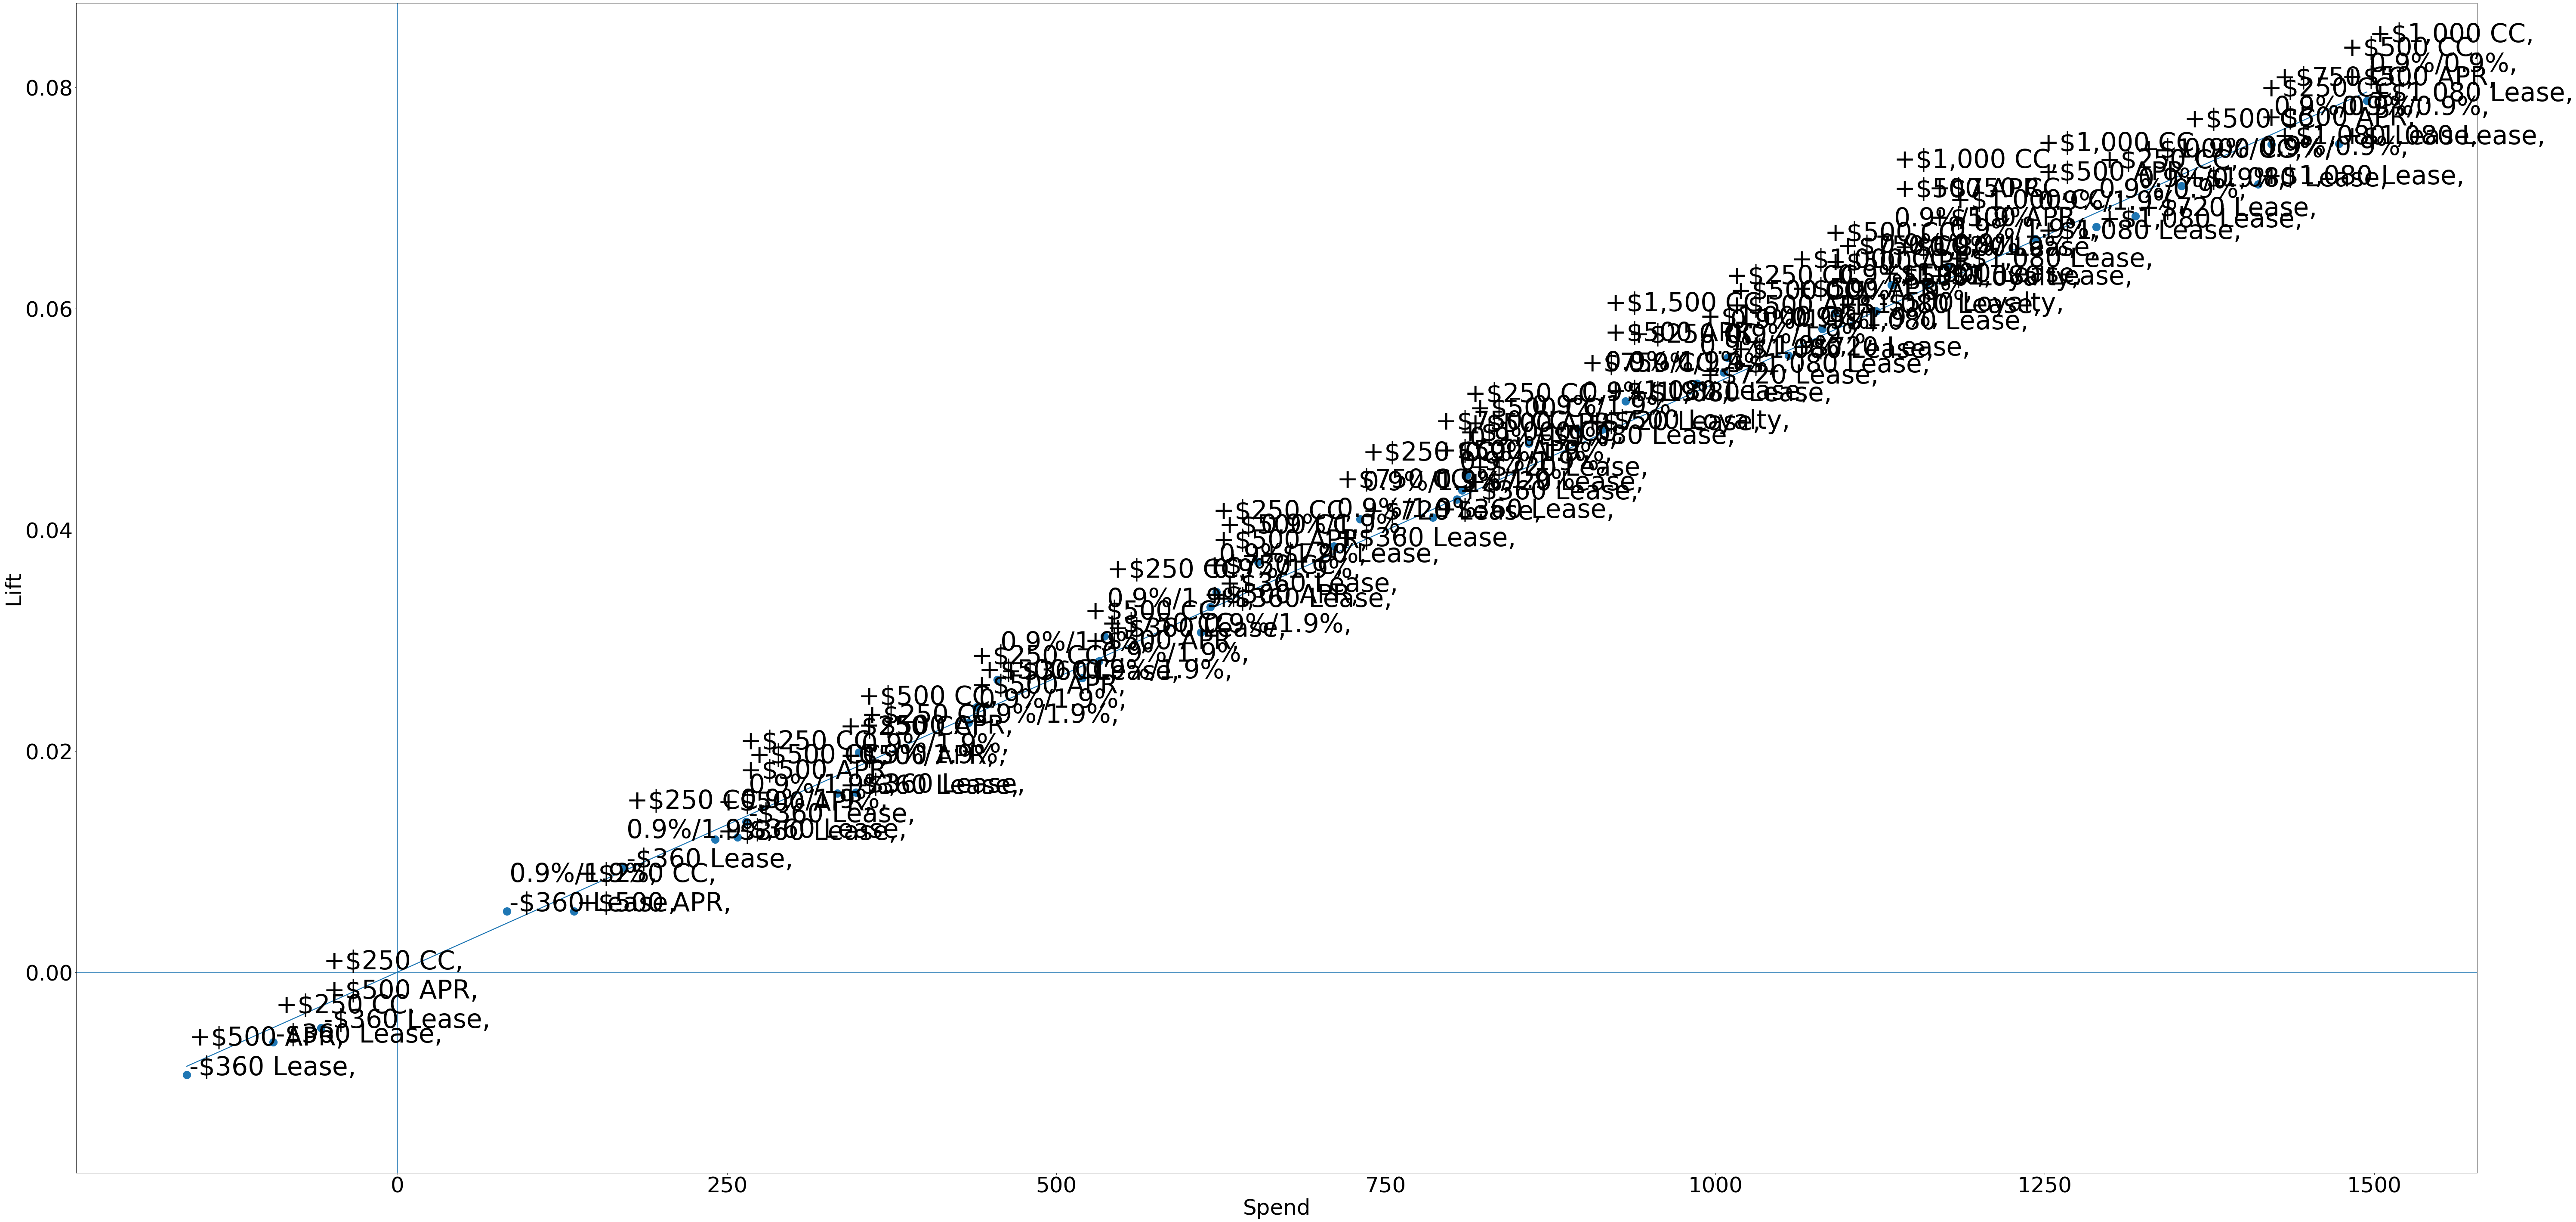

In [84]:
# Plot remaining scenarios w best fit line
fig, ax = plt.subplots()
p1 = sns.scatterplot(x=scenarios['spend_delta'], y=scenarios['lift_delta'], s=400)
p2 = sns.regplot(x=scenarios['spend_delta'], y=scenarios['lift_delta'], ci=0)

ax.axhline(y=0)
ax.axvline(x=0)
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
plt.xlabel('Spend', fontsize=50)
plt.ylabel('Lift', fontsize=50)
plt.rcParams["figure.figsize"] = (100,50)

# Label data points
for row in range(0, scenarios.shape[0]):
    p1.text(scenarios['spend_delta'].iloc[row]+2, scenarios['lift_delta'].iloc[row], scenarios['scenarios'].iloc[row], size=60)
      
plt.show()

In [85]:
scenarios_row = list(scenarios.index.values)

In [86]:
len(scenarios_row)

50

In [87]:
DSS_scenarios = [x + 1 for x in scenarios_row]
DSS_scenarios

[29,
 69,
 71,
 24,
 34,
 80,
 72,
 73,
 90,
 100,
 26,
 35,
 81,
 82,
 83,
 92,
 79,
 91,
 93,
 103,
 102,
 113,
 101,
 112,
 123,
 111,
 163,
 153,
 143,
 133,
 85,
 162,
 89,
 95,
 105,
 36,
 87,
 88,
 98,
 108,
 86,
 218,
 217,
 106,
 148,
 138,
 84,
 94,
 118,
 117]

In [88]:
scenarios = scenarios[scenarios['spend_delta'] > 0]
scenarios = scenarios[scenarios['spend_delta'] < spend_max]
scenarios_row = list(scenarios.index.values)

In [89]:
DSS_scenarios = [x + 1 for x in scenarios_row]
DSS_scenarios

[69,
 71,
 80,
 72,
 73,
 90,
 100,
 26,
 35,
 81,
 82,
 83,
 92,
 79,
 91,
 93,
 103,
 102,
 113,
 101,
 112,
 123,
 111,
 163,
 153,
 143,
 133,
 85,
 162,
 89,
 95,
 105,
 36,
 87,
 88,
 98,
 108,
 86,
 218,
 217,
 106,
 148,
 138,
 84,
 94,
 118,
 117]

In [323]:
def write_to_output_tab(DSS_file_path, tab_name, scenarios_row):
    wb = xw.Book(DSS_file_path)
    ws = wb.sheets[tab_name]
    
    for index, value in enumerate(scenarios_row):
        row_index = int(value) + 1
        ws.range(36+2*i, 8).value = value
        
    wb.save('new_wb.xlsm')

In [213]:
write_to_output_tab(DSS_file_path, tab_name, scenarios_row)